## Downloading logs_cnn folder from google drive

my logs_cnn folder is too big. So I kept it on google drive and the link is 
https://drive.google.com/drive/u/0/folders/1N2JlUg8GKi0bDQETATJ0U864F7mQ5EPC

In [1]:
!pip install gdown

distutils: /opt/anaconda3/include/python3.8/UNKNOWN
sysconfig: /opt/anaconda3/include/python3.8
user = False
home = None
root = None
prefix = None
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=6a55cc0a31c063982e2fad2448abb7ac75679cd5c3018d22fd6ff4dab840a8bb
  Stored in directory: /Users/agniksaha/Library/Caches/pip/wheels/7b/7b/5d/656f46cd6889e4c93977be9586901d0adc1271b2d876c84c96
Successfully built gdown
distutils: /opt/anaconda3/include/python3.8/UNKNOWN
sysconfig: /opt/anaconda3/include/python3.8
user = False
home = None
root = None
prefix = None
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [5]:
import gdown

In [26]:
url = "https://drive.google.com/drive/folders/1N2JlUg8GKi0bDQETATJ0U864F7mQ5EPC?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/Users/agniksaha/Downloads/pytorch_cl2/cnn_21CS60A01_agnik/cnn_best.pth']

### Importing necessary modules

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
import numpy as np
import shutil
import matplotlib.pyplot as plt

Save the weights corresponding to the minimum validation loss in a folder
‘logs_resnet/’
I am creating two folders named checkpoints and logs_resnet.
checkpoints will contain current checkpoints and logs_resnet will contain minimum validation loss

In [19]:
torch.manual_seed(1) # my roll is 21CS60A01..taking last two digits as 1

In [3]:
%mkdir logs_cnn 

### Loading training, validation and test dataset 

In [4]:
import pickle
with open("euroSAT_train_val_test.pkl", 'rb') as f:
    train_set, val_set, test_set = pickle.load(f)
    print (len(train_set), len(val_set), len(test_set)) # 18792 2808 5400
    print (train_set[0][0].shape, train_set[0][1]) # (3, 64, 64) 7

18792 2808 5400
(3, 64, 64) 7


###  Preparing train_loader , val_loader & test_loader

In [5]:
from torch.utils.data import DataLoader

train_loader  = DataLoader(train_set, batch_size = 64, shuffle= True)


In [6]:
val_loader = torch.utils.data.DataLoader(val_set,batch_size=64, shuffle=False)

In [7]:
test_loader=DataLoader(dataset=test_set, batch_size=64, shuffle=False)

This is the device selection. If anyone has gpu, the model will be trained faster

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### train_model function trains the model and this function returns training accuracy and training loss

In [9]:
def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Train Accuracy: {:.4f}'.format(total_loss, total_acc))
    return total_acc,total_loss

### validate_model function test the model and this function returns test accuracy and test loss

In [10]:
def validate_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Validation Loss: {:.4f}; Validation Accuracy: {:.4f}'.format(total_loss, total_acc))
    return total_acc,total_loss

### save_ckp function saves each checkpoint in checkpoint_path and best checkpoint in best_model_path

In [10]:
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

### Define our model

In [21]:
class Eurosat_CNN(nn.Module):
    def __init__(self):
        super(Eurosat_CNN,self).__init__()
        self.cnn1=nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.relu=nn.ReLU()
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2=nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.cnn3=nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, padding=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=2)

        self.fc1 =nn.Linear(in_features=192*4*4, out_features=1024)
        self.dropout= nn.Dropout(p=0.5)
        self.fc2 =nn.Linear(in_features=1024, out_features=512)
        self.fc3 =nn.Linear(in_features=512, out_features=10)
        
    def forward(self,x):
        #1st convolutional layer: 64 out channels, kernel size 3x3, stride 2, padding 1, 
        #followed by relu activation, and max pooling (with 2x2 subsampling)
        out =self.cnn1(x)
        out =self.relu(out)
        out =self.maxpool1(out)
        
        #2nd convolutional layer: 96 out channels, kernel size 3x3, padding 1, followed by relu
        #activation, and max pooling (with 2x2 subsampling
        out =self.cnn2(out)
        out =self.relu(out)
        out =self.maxpool2(out)
        
        #3rd convolutional layer: 192 out channels, kernel size 3x3, padding 1, followed by relu
        #activation and max pooling (with 2x2 subsampling).
        out =self.cnn3(out)
        out =self.relu(out)
        out =self.maxpool3(out)
        
        # Flatten the above layer and feed it to a linear layer with 1024 hidden units 
        #followed by relu activation
        out =out.view(-1,192*4*4)
        out =self.fc1(out)
        out =self.relu(out)
        # Add dropout with retention probability of 0.5
        out =self.dropout(out)
        # Again feed it to a linear layer with 512 hidden units followed by relu activation.
        out =self.fc2(out)
        out =self.relu(out) 
        # Add an output dense layer with 10 nodes
        out =self.fc3(out)
        return out

### Model fitting step

In [12]:
def fit(epochs,valid_loss_min):
    best_acc = 0 # variable to store best accuracy
    
    # lists to store accuracies and losses
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # our model
    model=Eurosat_CNN()
    CUDA=torch.cuda.is_available()
    if CUDA:
        model=model.cuda()

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # We'll optimize all parameters
    optimizer = optim.Adam(model.parameters())

    # train
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_acc, train_loss = train_model(model, loss_function, optimizer, train_loader)
        val_acc, valid_loss = validate_model(model, loss_function, val_loader)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(valid_loss)
        val_accuracies.append(val_acc)       



        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), './logs_cnn/cnn_best.pth')
            valid_loss_min = valid_loss
            
        # implementing early stopping code
        if val_acc > best_acc:
            best_acc = val_acc
            es = 0
        else:
            es += 1
            print("Counter {} of 5 (early stopping)".format(es))

            if es > 4:
                print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", val_acc, "...")
                break
                
    return train_losses,train_accuracies,val_losses,val_accuracies


In [13]:
valid_loss_min = np.Inf
epochs=15
train_losses,train_accuracies,val_losses,val_accuracies = fit(epochs,valid_loss_min)

Epoch 1/15
Train Loss: 1.4331; Train Accuracy: 0.4433
Validation Loss: 1.1702; Validation Accuracy: 0.5979
Validation loss decreased (inf --> 1.170192).  Saving model ...
Epoch 2/15
Train Loss: 0.8486; Train Accuracy: 0.6895
Validation Loss: 0.7941; Validation Accuracy: 0.7105
Validation loss decreased (1.170192 --> 0.794051).  Saving model ...
Epoch 3/15
Train Loss: 0.7275; Train Accuracy: 0.7355
Validation Loss: 0.6389; Validation Accuracy: 0.7710
Validation loss decreased (0.794051 --> 0.638855).  Saving model ...
Epoch 4/15
Train Loss: 0.6489; Train Accuracy: 0.7685
Validation Loss: 0.8126; Validation Accuracy: 0.7144
Counter 1 of 5 (early stopping)
Epoch 5/15
Train Loss: 0.5980; Train Accuracy: 0.7887
Validation Loss: 0.5525; Validation Accuracy: 0.8095
Validation loss decreased (0.638855 --> 0.552490).  Saving model ...
Epoch 6/15
Train Loss: 0.5318; Train Accuracy: 0.8119
Validation Loss: 0.5284; Validation Accuracy: 0.8209
Validation loss decreased (0.552490 --> 0.528421).  Sav

In [14]:
train_losses

[1.4331251618810388,
 0.8486292596165806,
 0.7274688624635358,
 0.6488911938088759,
 0.5979508732470517,
 0.5318148748678774,
 0.47501684352914136,
 0.4418496351741435,
 0.3963762348689846,
 0.3649646963348486,
 0.34061348831567323,
 0.30851927584868993,
 0.28914236008689576,
 0.25522164216684556,
 0.23661878908020528]

In [15]:
train_accuracies 

[tensor(0.4433, dtype=torch.float64),
 tensor(0.6895, dtype=torch.float64),
 tensor(0.7355, dtype=torch.float64),
 tensor(0.7685, dtype=torch.float64),
 tensor(0.7887, dtype=torch.float64),
 tensor(0.8119, dtype=torch.float64),
 tensor(0.8322, dtype=torch.float64),
 tensor(0.8452, dtype=torch.float64),
 tensor(0.8647, dtype=torch.float64),
 tensor(0.8698, dtype=torch.float64),
 tensor(0.8806, dtype=torch.float64),
 tensor(0.8919, dtype=torch.float64),
 tensor(0.8996, dtype=torch.float64),
 tensor(0.9129, dtype=torch.float64),
 tensor(0.9159, dtype=torch.float64)]

In [16]:
val_losses

[1.1701920779681954,
 0.7940513834654436,
 0.6388549293547954,
 0.8126260981260881,
 0.5524895368648051,
 0.5284211525210628,
 0.46464393052280456,
 0.4216722624424176,
 0.4376725539183005,
 0.43171841992951526,
 0.39771440221882953,
 0.4343538245669118,
 0.4226528451992915,
 0.3866415560415328,
 0.42539576893178827]

In [17]:
val_accuracies

[tensor(0.5979, dtype=torch.float64),
 tensor(0.7105, dtype=torch.float64),
 tensor(0.7710, dtype=torch.float64),
 tensor(0.7144, dtype=torch.float64),
 tensor(0.8095, dtype=torch.float64),
 tensor(0.8209, dtype=torch.float64),
 tensor(0.8351, dtype=torch.float64),
 tensor(0.8568, dtype=torch.float64),
 tensor(0.8529, dtype=torch.float64),
 tensor(0.8547, dtype=torch.float64),
 tensor(0.8697, dtype=torch.float64),
 tensor(0.8479, dtype=torch.float64),
 tensor(0.8572, dtype=torch.float64),
 tensor(0.8682, dtype=torch.float64),
 tensor(0.8543, dtype=torch.float64)]

## Plots of loss and accuracy on the training and validation sets

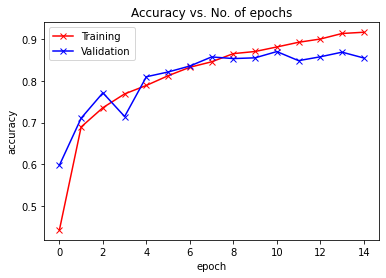

In [18]:
# importing the required module

def plot_accuracies(train_accuracies,val_accuracies):
    plt.plot(train_accuracies, '-rx')
    plt.plot(val_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

    


plot_accuracies(train_accuracies,val_accuracies)

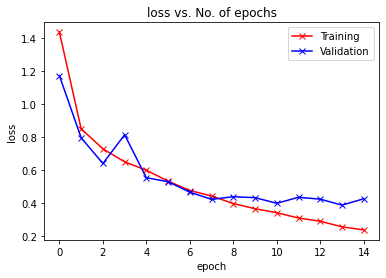

In [19]:
def plot_losses(train_losses,val_losses):
    plt.plot(train_losses, '-rx')
    plt.plot(val_losses, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('loss vs. No. of epochs')

    


plot_losses(train_losses,val_losses)

## Loading the model
- Load the state dict to the model


In [27]:
model = Eurosat_CNN()
model.load_state_dict(torch.load('./cnn_best.pth'))
model.to(device)

Eurosat_CNN(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [21]:
print("model = ", model)

model =  Eurosat_CNN(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [25]:
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

## Output the predicted value from a test dataset

In [22]:
def get_all_preds(model, loader):
    preds = torch.tensor([])
    true_labels = torch.tensor([])
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels = torch.cat((true_labels,labels),dim = 0)
            preds = torch.cat((preds,predicted),dim = 0)
    return true_labels,preds

### REPORT THE ACCURACY ON TEST DATA

In [23]:
labels,preds = get_all_preds(model, test_loader)

In [24]:
count = 0
for i in range(len(labels)):
    if preds[i] == labels[i]:
        count = count+1
acc_test = count/ len(labels)
print(f'Accuracy of test data is {acc_test}\n')

Accuracy of test data is 0.8637037037037038



### REPORT THE ACCURACY ON VALIDATION DATA

In [25]:
labels_val,preds_val = get_all_preds(model, val_loader)
count1 = 0
for i in range(len(labels_val)):
    if preds_val[i] == labels_val[i]:
        count1 = count1+1
acc_val = count1/ len(labels_val)
print(f'Accuracy of validation data is {acc_val}\n')

Accuracy of validation data is 0.8596866096866097



## Plot confusion matrix

In [26]:
y_true, y_pred = get_all_preds(model, test_loader)

In [27]:
classes = ('AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake') 

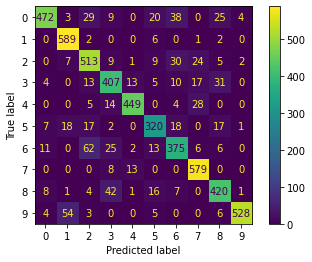

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Show the recall for each class

In [29]:
from sklearn.metrics import recall_score

In [30]:
y_true, y_pred = get_all_preds(model, test_loader)
y_true = y_true.tolist()
y_pred = y_pred.tolist()
recall = recall_score(y_true, y_pred, average=None)
print(recall)

[0.78833333 0.98       0.85166667 0.814      0.908      0.83
 0.756      0.96833333 0.836      0.88333333]


In [31]:
preds = [int(x) for x in preds]

In [32]:
f = open("result_task_1.csv", "w+")
f.write(f'id,label\n')
count = 0
for pred in preds:
    f.write(f'{count},{pred}\n')
    count = count+1
f.close()